In [1]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt
from skimage.segmentation import felzenszwalb, slic, random_walker
from skimage.segmentation import mark_boundaries, find_boundaries, relabel_sequential
from skimage.color import label2rgb

### Select And Display 10 Test Images with Their GroundTruth

In [2]:
selected = ['007','010', '011','016', '023','029','035','038','042','048' ]
image_arr=[]
gt_arr=[]

for number in selected:
    name = 'dataset/test/SL_'+number+'.jpg'
    gt='dataset/groundtruth/SL_GT_'+number+'.png'
    image = cv2.imread(name)
    #image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gt_image= cv2.imread(gt,0)
    image_arr.append(image)
    gt_arr.append(gt_image)
    

In [10]:
def printImageArr(image_arr,x,y,size):
    
    plt.figure(figsize=(x,y))
    
    for index,image in enumerate(image_arr):
        image_arr[index] = cv2.cvtColor(image_arr[index], cv2.COLOR_BGR2RGB)
        plt.subplot(1,size,index+1), plt.imshow(image_arr[index])
        plt.xlabel(str(selected[index])), plt.xticks([]), plt.yticks([])
    plt.show()

def printMapArr(image_arr,x,y,size):
    plt.figure(figsize=(x,y))
    
    for index,image in enumerate(image_arr):
        plt.subplot(1,size,index+1), plt.imshow(image_arr[index],cmap='gray')
        plt.xlabel(str(selected[index])), plt.xticks([]), plt.yticks([])
    plt.show()

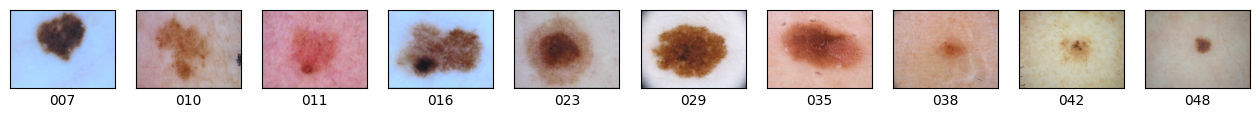

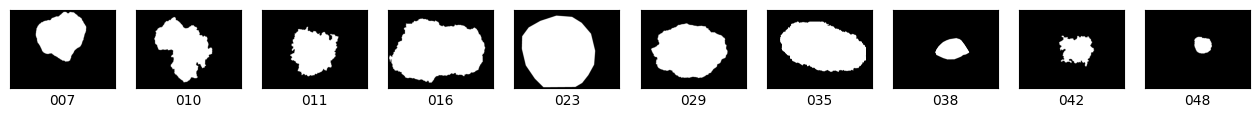

In [11]:
printImageArr(image_arr,16,10,10)
printMapArr(gt_arr,16,10,10)

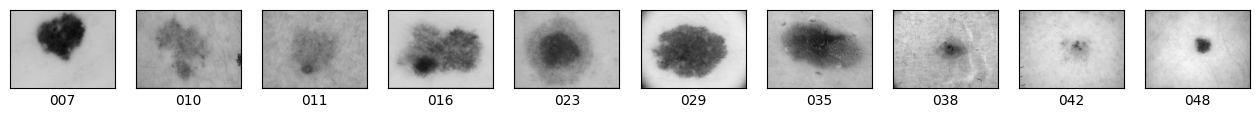

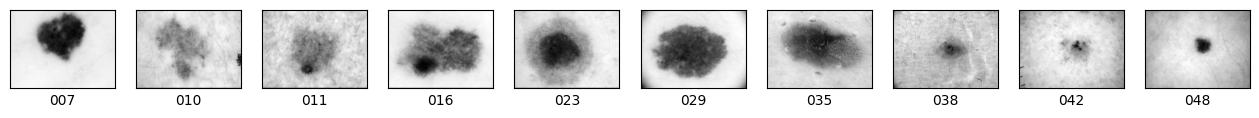

In [5]:
kernelSize=(9,9)
blur_arr=list(map(lambda x:cv2.GaussianBlur(x, kernelSize,100),image_arr))
printImageArr(image_arr,16,10,10)
printImageArr(blur_arr,16,10,10)

### 1. Use Felzenszwalb Algorithm

In [6]:
fz_segments = list(map(lambda x: felzenszwalb(x, scale=70, sigma=0.5, min_size=150),blur_arr))
#print(fz_segments)

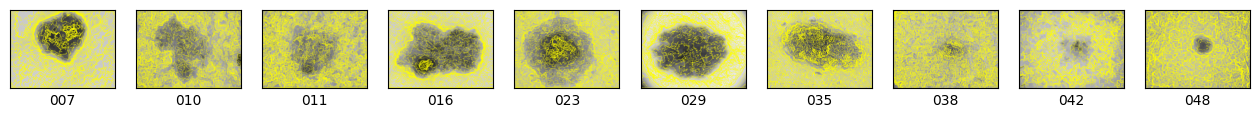

In [7]:
fz_boundaries=[]
for x in range (len(fz_segments)):
    fz_boundary = mark_boundaries(blur_arr[x], fz_segments[x])
    fz_boundaries.append(fz_boundary)

printImageArr(fz_boundaries,16,10,10)

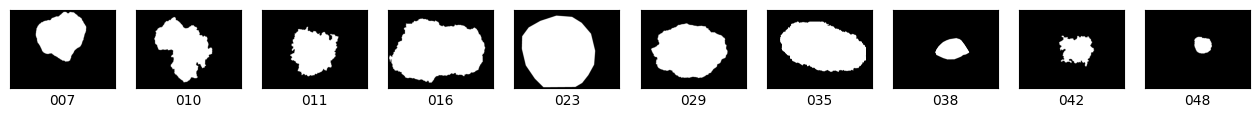

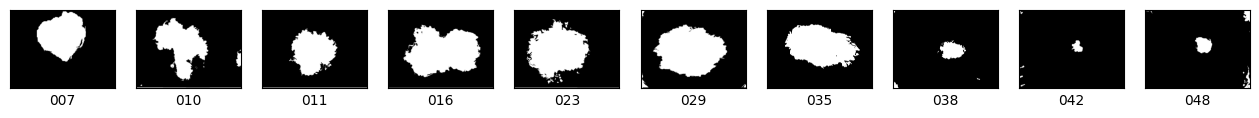

In [8]:
fz_results=[]
for x in range (len(fz_boundaries)):
    bgc= np.round(np.mean(blur_arr[x][fz_segments[x]==0],axis=0))
    fz_result = label2rgb(fz_segments[x],blur_arr[x],kind='avg',bg_label=0,bg_color=bgc)
    fz_result = cv2.threshold(fz_result,140,255,cv2.THRESH_BINARY)[1]
    fz_result = cv2.bitwise_not(fz_result)
    fz_results.append(fz_result)

printImageArr(gt_arr,16,10,10)
printImageArr(fz_results,16,10,10)

## 2. Do the same thing but with SLIC

In [9]:
slic_segments = list(map(lambda x: slic(x,n_segments=128,sigma=5,channel_axis=None),blur_arr))

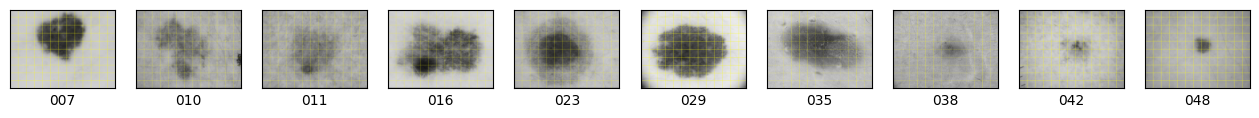

In [10]:
slic_boundaries=[]
for x in range (len(slic_segments)):
    slic_boundary = mark_boundaries(blur_arr[x], slic_segments[x])
    slic_boundaries.append(slic_boundary)

printImageArr(slic_boundaries,16,10,10)

/home/haziq/Documents/VIP/vip-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haziq/Documents/VIP/vip-env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


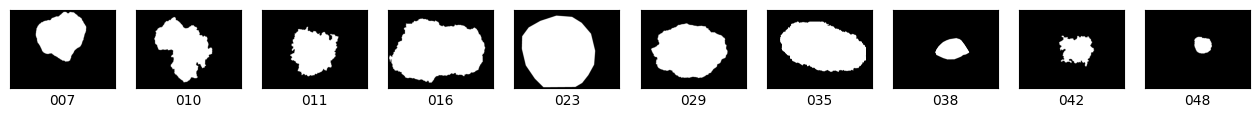

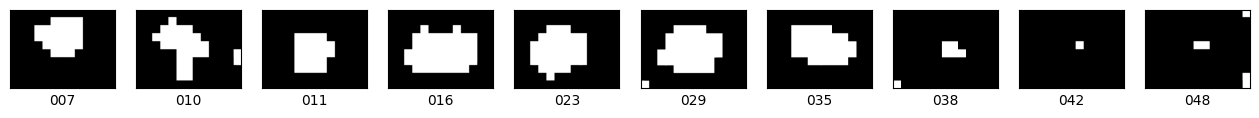

In [11]:
slic_results=[]
for x in range (len(slic_boundaries)):
    bgc= np.round(np.mean(blur_arr[x][slic_segments[x]==0],axis=0))
    slic_result = label2rgb(slic_segments[x],blur_arr[x],kind='avg',bg_label=0,bg_color=bgc)
    slic_result = cv2.threshold(slic_result,140,255,cv2.THRESH_BINARY)[1]
    slic_result = cv2.bitwise_not(slic_result)
    slic_results.append(slic_result)

printImageArr(gt_arr,16,10,10)
printImageArr(slic_results,16,10,10)

## 3. Use GrabCut Initialized With A Bounding Box

In [12]:
gc_image = blur_arr[1]
gc_image = cv2.cvtColor(gc_image, cv2.COLOR_BGR2RGB)
plt.imshow(gc_image)
plt.show()

NameError: name 'blur_arr' is not defined

In [16]:
# Define boundary rectangle containing the foreground object
height, width = gc_image.shape
left_margin_proportion = 0.2
right_margin_proportion = 0.2
up_margin_proportion = 0.1
down_margin_proportion = 0.1

boundary_rectangle = (
    int(width * left_margin_proportion),
    int(height * up_margin_proportion),
    int(width * (1 - right_margin_proportion)),
    int(height * (1 - down_margin_proportion)),
)

# Set the seed for reproducibility purposes
cv2.setRNGSeed(0)

#Remove alpha channel
gc_image=cv2.cvtColor(gc_image, cv2.COLOR_GRAY2BGR)

# Initialize GrabCut mask image, that will store the segmentation results
mask = np.zeros((height, width), np.uint8)

# Arrays used by the algorithm internally
background_model = np.zeros((1, 65), np.float64)
foreground_model = np.zeros((1, 65), np.float64)

number_of_iterations = 10

cv2.grabCut(
    img=gc_image,
    mask=mask,
    rect=boundary_rectangle,
    bgdModel=background_model,
    fgdModel=foreground_model,
    iterCount=number_of_iterations,
    mode=cv2.GC_INIT_WITH_RECT,
)

grabcut_mask = np.where((mask == cv2.GC_PR_BGD) | (mask == cv2.GC_BGD), 0, 1).astype(
    "uint8"
)

segmented_image = gc_image.copy() * grabcut_mask[:, :, np.newaxis]

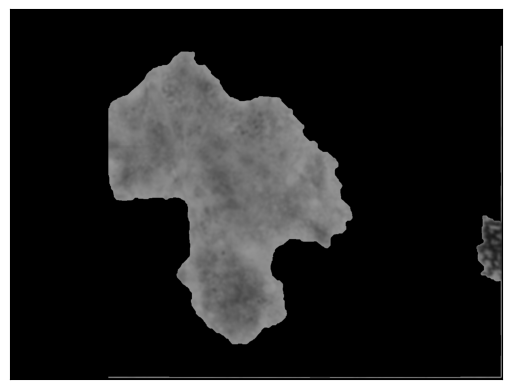

In [17]:
plt.imshow(segmented_image), plt.xticks([]), plt.yticks([])
plt.show()

In [18]:
# Binarize input image
gray_image = cv2.cvtColor(gc_image, cv2.COLOR_BGR2GRAY)

_,binarized_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_OTSU)
#binarized_image = cv2.adaptiveThreshold(gray_image,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)


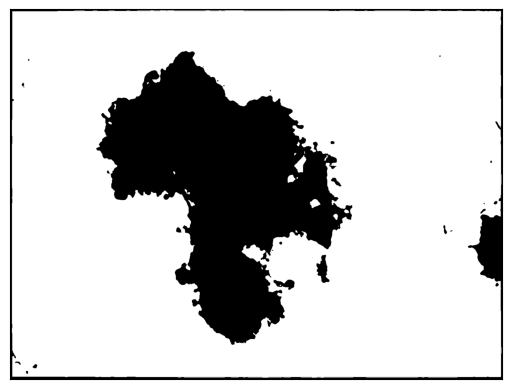

In [19]:
plt.imshow(binarized_image,cmap='gray'), plt.xticks([]), plt.yticks([])
plt.show()

In [20]:
# Initialize the mask with known information
mask = np.zeros((height, width), np.uint8)
mask[:] = cv2.GC_PR_BGD
mask[binarized_image == 0] = cv2.GC_FGD

In [21]:
# Arrays used by the algorithm internally
background_model = np.zeros((1, 65), np.float64)
foreground_model = np.zeros((1, 65), np.float64)

cv2.grabCut(
    gc_image,
    mask,
    boundary_rectangle,
    background_model,
    foreground_model,
    number_of_iterations,
    cv2.GC_INIT_WITH_MASK,
)

(array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint8),
 array([[1.23536305e-01, 2.34886668e-01, 3.25579364e-01, 7.66051812e-02,
         2.39392481e-01, 1.56196000e+02, 1.56196000e+02, 1.56196000e+02,
         1.75685133e+02, 1.75685133e+02, 1.75685133e+02, 1.67873085e+02,
         1.67873085e+02, 1.67873085e+02, 1.50386866e+02, 1.50386866e+02,
         1.50386866e+02, 1.61704429e+02, 1.61704429e+02, 1.61704429e+02,
         1.97522180e+00, 1.96522180e+00, 1.96522180e+00, 1.96522180e+00,
         1.97522180e+00, 1.96522180e+00, 1.96522180e+00, 1.96522180e+00,
         1.97522180e+00, 9.09626892e+00, 9.08626892e+00, 9.08626892e+00,
         9.08626892e+00, 9.09626892e+00, 9.08626892e+00, 9.08626892e+00,
         9.08626892e+00, 9.09626892e+00, 3.79708089e+00, 3.78708089e+00,
         3.78708089e+00, 3.78708089e+00, 3.7

In [22]:
grabcut_mask = np.where((mask == cv2.GC_PR_BGD) | (mask == cv2.GC_BGD), 0, 1).astype(
    "uint8"
)
segmented_image = gc_image.copy() * grabcut_mask[:, :, np.newaxis]

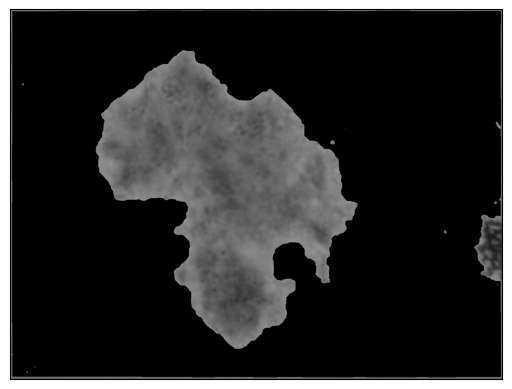

In [ ]:
#_,segmented_image = cv2.threshold(segmented_image, 128, 255, cv2.THRESH_OTSU)
plt.imshow(segmented_image), plt.xticks([]), plt.yticks([])
plt.show()

In [25]:
new = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

In [26]:
new.shape

(1129, 1504)

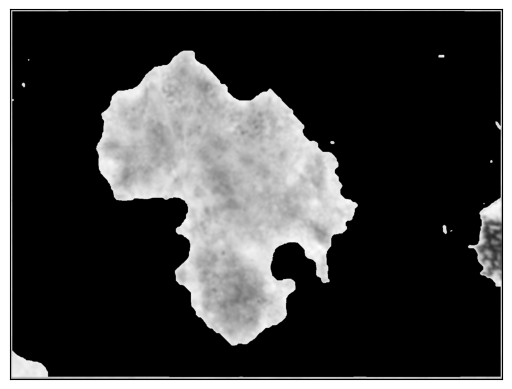

In [28]:
#_,segmented_image = cv2.threshold(segmented_image, 128, 255, cv2.THRESH_OTSU)
plt.imshow(new,cmap='gray'), plt.xticks([]), plt.yticks([])
plt.show()

In [29]:
_,new2 = cv2.threshold(new, 128, 255, cv2.THRESH_OTSU)

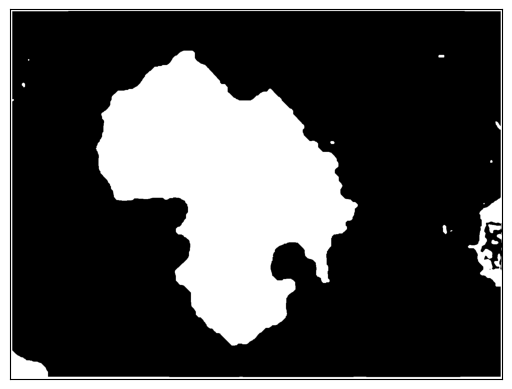

In [30]:
#_,segmented_image = cv2.threshold(segmented_image, 128, 255, cv2.THRESH_OTSU)
plt.imshow(new2,cmap='gray'), plt.xticks([]), plt.yticks([])
plt.show()

In [37]:
from sklearn.metrics import precision_score,recall_score,jaccard_score
jaccard_score(gt_arr[1].reshape(-1),new2.reshape(-1),pos_label=255)

0.8013030000525403

In [32]:
gt_arr[1].shape

(1129, 1504)

In [33]:
new2.shape

(1129, 1504)

In [34]:
np.unique(new2)

array([  0, 255], dtype=uint8)

In [35]:
np.unique(gt_arr[1])

array([  0, 255], dtype=uint8)

In [ ]:
def predictImage(img):
    